# Amazon Augmented AI(A2I) Integrated with AWS Marketplace ML Models

Sometimes, for some payloads, machine learning (ML) model predictions are just not confident enough and you want more than a machine. Furthermore, training a model can be complicated, time-consuming, and expensive. This is where [AWS Marketplace](https://aws.amazon.com/marketplace/b/6297422012?page=1&filters=FulfillmentOptionType&FulfillmentOptionType=SageMaker) and [Amazon Augmented AI](https://aws.amazon.com/augmented-ai/) (Amazon A2I) come in. By combining a pretrained ML model in AWS Marketplace with Amazon Augmented AI, you can quickly reap the benefits of pretrained models with validating and augmenting the model's accuracy with human intelligence.

AWS Marketplace contains over 400 pretrained ML models. Some models are general purpose. For example, the [GluonCV SSD Object Detector](https://aws.amazon.com/marketplace/pp/prodview-ggbuxlnrm2lh4?qid=1605041213915&sr=0-5&ref_=brs_res_product_title) can detect objects in an image and place bounding boxes around the objects. AWS Marketplace also offers many purpose-built models such as a [Background Noise Classifier](https://aws.amazon.com/marketplace/pp/prodview-vpd6qdjm4d7u4?ref_=beagle&applicationId=AWS-Sagemaker-Console), a [Hard Hat Detector for Worker Safety](https://aws.amazon.com/marketplace/pp/prodview-jd5tj2egpxxum?ref_=beagle&applicationId=AWS-Sagemaker-Console), and a [Person in Water](https://aws.amazon.com/marketplace/pp/prodview-wlndemzv5pxhw?ref_=beagle&applicationId=AWS-Sagemaker-Console).

Amazon A2I provides a human-in-loop workflow to review ML predictions. Its configurable human-review workflow solution and customizable user-review console enable you to focus on ML tasks and increase the accuracy of the predictions with human input.

## Overview

In this notebook, you will use a pre-trained AWS Marketplace machine learning model with Amazon A2I to detect images as well as trigger a human-in-loop workflow to review, update and add additional labeled objects to an individual image. Furthermore, you can specify configurable threshold criteria for triggering the human-in-loop workflow in Amazon A2I. For example, you can trigger a human-in-loop workflow if there are no objects that are detected with an accuracy of 90% or greater.

The following diagram shows the AWS services that are used in this notebook and the steps that you will perform. Here are the high level steps in this notebook:
1.	Configure the human-in-loop review using Amazon A2I
1.	Select, deploy, and invoke an AWS Marketplace ML model
1.	Trigger the human review workflow in Amazon A2I.
1.	The private workforce that was created in Amazon SageMaker Ground Truth reviews and edits the objects detected in the image.


<img style="float: center;" src="./img/a2i_diagram.png" width="700" height="500">

## Contents

* [Prerequisites](#Prerequisites)
* [Step 1 Configure Amazon A2I service](#step1)
    * [Step 1.1 Creating human review Workteam or Workforce](#step1_1)
    * [Step 1.2 Create Human Task UI](#step1_2)
    * [Step 1.3 Create the Flow Definition](#step1_3)
* [Step 2 Deploy and invoke AWS Marketplace model](#step2)
    * [Step 2.1 Create an endpoint](#step2_1)
    * [Step 2.2 Create input payload](#step2_2)
    * [Step 2.3 Perform real-time inference](#step2_3)
* [Step3 Starting Human Loops](#step3)
    * [Step 3.1 View Task Results](#step3_1)
* [Step 4 Next steps](#step4)
    * [Step 4.1 Additional resources](#step4_1)
* [Step 5 Cleanup Resources](#step5)

### Usage instructions
You can run this notebook one cell at a time (By using Shift+Enter for running a cell).

## Prerequisites <a class="anchor" id="prerequisites"></a>

This sample notebook requires a subscription to **[GluonCV SSD Object Detector](https://aws.amazon.com/marketplace/pp/prodview-ggbuxlnrm2lh4)**, a pre-trained machine learning model package from AWS Marketplace. 
If your AWS account has not been subscribed to this listing, here is the process you can follow: 
1. Open the [listing](https://aws.amazon.com/marketplace/pp/prodview-ggbuxlnrm2lh4) from AWS Marketplace
1. Read the **Highlights** section and then **product overview** section of the listing.
1. View **usage information** and then **additional resources.**
1. Note the supported instance types.
1. Next, click on **Continue to subscribe.**
1. Review **End-user license agreement, support terms**, as well as **pricing information.**
1. **"Accept Offer"** button needs to be clicked if your organization agrees with EULA, pricing information as well as support terms.  If **Continue to configuration** button is active, it means your account already has a subscription to this listing. Once you click on **Continue to configuration** button and then choose region, you will see that a Product Arn will appear. This is the model package ARN that you need to specify in the following cell.

In [1]:
model_package_arn = "arn:aws:sagemaker:us-east-1:865070037744:model-package/gluoncv-ssd-resnet501547760463-0f9e6796d2438a1d64bb9b15aac57bc0" # Update as needed

8. This notebook requires the IAM role associated with this notebook to have *AmazonSageMakerFullAccess* IAM permission.

8. Note: If you want to run this notebook on AWS SageMaker Studio - please use Classic Jupyter mode to be able correctly render visualization. Pick instance type **'ml.m4.xlarge'** or larger. Set kernel to **'Data Science'**.

    <img style="float: left;" src="./img/classicjupyter.png">

### Installing Dependencies

Import the libraries that are needed for this notebook.

In [2]:
#Import necessary libraries
import boto3
import json
import pandas as pd
import pprint
import requests
import sagemaker
import shutil
import time
import uuid
import PIL.Image
from IPython.display import Image
from IPython.display import Markdown as md
from sagemaker import get_execution_role
from sagemaker import ModelPackage

#### Setup Variables, Bucket and Paths

In [3]:
# Setting Role to the default SageMaker Execution Role
role = get_execution_role()

# Instantiate the SageMaker session and client that will be used throughout the notebook
sagemaker_session = sagemaker.Session()
sagemaker_client = sagemaker_session.sagemaker_client

# Fetch the region 
region = sagemaker_session.boto_region_name

# Create S3 and A2I clients
s3 = boto3.client('s3', region)
a2i = boto3.client('sagemaker-a2i-runtime', region)

# Retrieve the current timestamp
timestamp = time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

# endpoint_name = '<ENDPOINT_NAME>'
endpoint_name='gluoncv-object-detector'

#content_type='<CONTENT_TYPE>'
content_type='image/jpeg'

# Instance size type to be used for making real-time predictions
real_time_inference_instance_type='ml.m4.xlarge'

# Task UI name - this value is unique per account and region. You can also provide your own value here.
# task_ui_name = '<TASK_UI_NAME>'
task_ui_name = 'ui-aws-marketplace-gluon-model-' + timestamp

# Flow definition name - this value is unique per account and region. You can also provide your own value here.
flow_definition_name = 'fd-aws-marketplace-gluon-model-' + timestamp

# Name of the image file that will be used in object detection
image_file_name='image.jpg'

In [4]:
# Create the sub-directory in the default S3 bucket
# that will store the results of the human-in-loop A2I review
bucket = sagemaker_session.default_bucket()
key = 'a2i-results'
s3.put_object(Bucket=bucket, Key=(key+'/'))
output_path = f's3://{bucket}/a2i-results'
print(f"Results of A2I will be stored in {output_path}.")

Results of A2I will be stored in s3://sagemaker-us-east-1-126797685573/a2i-results.


## Step 1 Configure Amazon A2I service<a class="anchor" id="step1"></a>
In this section, you will create 3 resources:
1. Private workforce
2. Human-in-loop Console UI
3. Workflow definition

### Step 1.1 Creating human review Workteam or Workforce <a class="anchor" id="step1_1"></a>

To create your Private workforce, visit the instructions here: https://docs.aws.amazon.com/sagemaker/latest/dg/sms-workforce-private.html

#### NOTE: After you have created your workteam, replace `<WORKTEAM_ARN>` below:

In [5]:
# workteam_arn = '<WORKTEAM_ARN>'
workteam_arn = 'arn:aws:sagemaker:us-east-1:126797685573:workteam/private-crowd/aa'

### Step 1.2 Create Human Task UI <a class="anchor" id="step1_2"></a>

Create a human task UI resource, giving a UI template in liquid HTML. This template will be rendered to the human workers whenever human loop is required.

For additional UI templates, check out this repository:  https://github.com/aws-samples/amazon-a2i-sample-task-uis.

You will be using a slightly modified version of the [object detection UI](https://github.com/aws-samples/amazon-a2i-sample-task-uis/blob/master/images/bounding-box.liquid.html) that provides support for the `initial-value` and `labels` variables in the template.

In [6]:
# Create task UI

# Read in the template from a local file
template = open("./src/worker-task-template.html").read()

human_task_ui_response = sagemaker_client.create_human_task_ui(
        HumanTaskUiName=task_ui_name,
        UiTemplate={'Content': template})

human_task_ui_arn = human_task_ui_response['HumanTaskUiArn']
print(human_task_ui_arn)

arn:aws:sagemaker:us-east-1:126797685573:human-task-ui/ui-aws-marketplace-gluon-model-2021-01-26-23-39-37


### Step 1.3 Create the Flow Definition <a class="anchor" id="step1_3"></a>

In this section, you will create a flow definition. Flow Definitions allow you to specify:

* The workforce that your tasks will be sent to.
* The instructions that your workforce will receive. This is called a worker task template.
* The configuration of your worker tasks, including the number of workers that receive a task and time limits to complete tasks.
* Where your output data will be stored.

For more details and instructions, see: https://docs.aws.amazon.com/sagemaker/latest/dg/a2i-create-flow-definition.html.

In [7]:
create_workflow_definition_response = sagemaker_client.create_flow_definition(
        FlowDefinitionName= flow_definition_name,
        RoleArn= role,
        HumanLoopConfig= {
            "WorkteamArn": workteam_arn,
            "HumanTaskUiArn": human_task_ui_arn,
            "TaskCount": 1,
            "TaskDescription": "Identify and locate the object in an image.",
            "TaskTitle": "Object detection Amazon A2I demo"
        },
        OutputConfig={
            "S3OutputPath" : output_path
        }
    )
flow_definition_arn = create_workflow_definition_response['FlowDefinitionArn'] # let's save this ARN for future use

In [8]:
%%time

# Describe flow definition - status should be active
for x in range(60):
    describe_flow_definition_response = sagemaker_client.describe_flow_definition(FlowDefinitionName=flow_definition_name)
    print(describe_flow_definition_response['FlowDefinitionStatus'])
    if (describe_flow_definition_response['FlowDefinitionStatus'] == 'Active'):
        print("Flow Definition is active")
        break
    time.sleep(2)

Initializing
Active
Flow Definition is active
CPU times: user 9.1 ms, sys: 0 ns, total: 9.1 ms
Wall time: 2.16 s


## Step 2 Deploy and invoke AWS Marketplace model <a class="anchor" id="step2"></a>

In this section, you will stand up an Amazon SageMaker endpoint. Each endpoint must have a unique name which you can use for performing inference. 

### Step 2.1 Create an Endpoint <a class="anchor" id="step2_1"></a>

In [9]:
%%time

# Create a deployable model from the model package.
model = ModelPackage(role=role,
                    model_package_arn=model_package_arn,
                    sagemaker_session=sagemaker_session,
                    predictor_cls=sagemaker.predictor.Predictor)

#Deploy the model
predictor = model.deploy(initial_instance_count=1, 
                         instance_type=real_time_inference_instance_type, 
                         endpoint_name=endpoint_name)

---------------!CPU times: user 226 ms, sys: 15.7 ms, total: 241 ms
Wall time: 7min 32s


It will take anywhere between 5 to 10 minutes to create the endpoint. Once the endpoint has been created, you would be able to perform real-time inference.

### Step 2.2 Create input payload <a class="anchor" id="step2_2"></a>

In this step, you will prepare a payload to perform a prediction.

In [10]:
# Download the image file
# Open the url image, set stream to True, this will return the stream content.
r = requests.get("https://images.pexels.com/photos/763398/pexels-photo-763398.jpeg", stream = True)

# Open a local file with wb ( write binary ) permission to save it locally.
with open(image_file_name,'wb') as f:
    shutil.copyfileobj(r.raw, f)

Resize the image and upload the file to S3 so that the image can be referenced from the worker console UI.

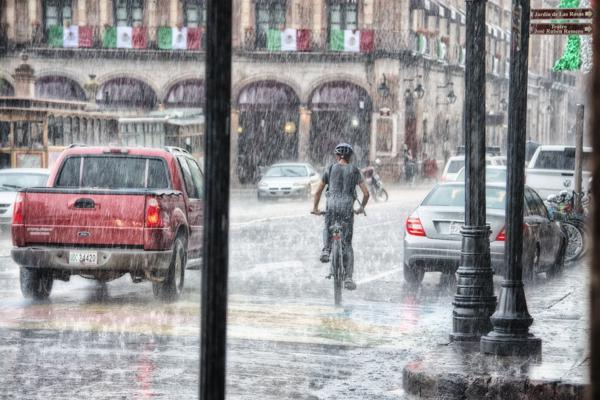

In [11]:
# Load the image
image = PIL.Image.open(image_file_name)
# Resize the image
resized_image=image.resize((600,400))

# Save the resized image file locally
resized_image.save(image_file_name)

# Save file to S3
s3 = boto3.client('s3')
with open(image_file_name, "rb") as f:
    s3.upload_fileobj(f, bucket, image_file_name)

# Display the image
from IPython.core.display import Image, display
Image(filename = image_file_name, width=600, height = 400)

### Step 2.3 Perform real-time inference <a class="anchor" id="step2_3"></a>

Submit the image file to the model and it will detect the objects in the image.

In [12]:
with open(image_file_name, 'rb') as f:
    payload = f.read()

response = sagemaker_session.sagemaker_runtime_client.invoke_endpoint(EndpointName=endpoint_name, \
                                 ContentType=content_type, \
                                 Accept='json', \
                                 Body=payload)

result = json.loads(response['Body'].read().decode())

# Convert list to JSON
json_result = json.dumps(result)
df = pd.read_json(json_result)

# Display confidence scores < 0.90
df = df[df.score < 0.90]
print(df.head())

   right  bottom  top     score          id  left
4     49     226  169  0.820281         car     0
5    587     203  144  0.715680         car   524
6    585     260  200  0.500341     bicycle   552
7    354     295  209  0.392019     bicycle   325
8    389     201  165  0.380264  motorcycle   362


## Step 3 Starting Human Loops <a class="anchor" id="step3"></a>

In a previous step, you have already submitted your image to the model for prediction and stored the output in JSON format in the `result` variable. You simply need to modify the X, Y coordinates of the bounding boxes. Additionally, you can filter out all predictions that are less than 90% accurate before submitting it to your human-in-loop review. This will insure that your model's predictions are highly accurate and any additional detections of objects will be made by a human.

In [13]:
# Helper function to update X,Y coordinates and labels for the bounding boxes
def fix_boundingboxes (prediction_results, threshold=0.8):

    bounding_boxes=[]
    labels=set()
    
    for data in prediction_results:
        label = data['id']
        labels.add(label)
        
        if data['score'] > threshold:
            width = data['right'] - data['left']
            height = data['bottom'] - data['top']   
            top = data['top']
            left = data['left']
            bounding_boxes.append({'height':height, 'width':width, 'top':top, 'left':left, 'label':label})
            
    return bounding_boxes, list(labels)    

bounding_boxes, labels = fix_boundingboxes(result, threshold=0.9)

In [14]:
# Define the content that is passed into the human-in-loop workflow and console
human_loop_name = str(uuid.uuid4())
input_content = {
    "initialValue": bounding_boxes, # the bounding box values that have been detected by model prediction
    "taskObject": f's3://{bucket}/'+ image_file_name, # the s3 object will be passed to the worker task UI to render
    "labels": labels # the labels that are displayed in the legend
}

# Trigger the human-in-loop workflow
start_loop_response = a2i.start_human_loop(
            HumanLoopName=human_loop_name,
            FlowDefinitionArn=flow_definition_arn,
            HumanLoopInput={
                "InputContent": json.dumps(input_content)
            }
)

Now that the human-in-loop review has been triggered, you can log into the worker console to work on the task and make edits and additions to the object detection bounding boxes from the image.

In [15]:
# Fetch the URL for the worker console UI
workteam_name = workteam_arn.split('/')[-1]
my_workteam = sagemaker_session.sagemaker_client.list_workteams(NameContains=workteam_name)
worker_console_url = 'https://' + my_workteam['Workteams'][0]['SubDomain']

md("### Click on the [Worker Console]({}) to begin reviewing the object detection".format(worker_console_url))

### Click on the [Worker Console](https://dyk66qg8ak.labeling.us-east-1.sagemaker.aws) to begin reviewing the object detection

The below image shows the objects that were detected for the sample image that was used in this notebook by your model and displayed in the worker console. 

<img src='./img/rain_biker_bb.png' align='center' height=600 width=800/>

You can now make edits to the image to detect other objects. For example, in the image above, the model failed to detect the bicycle in the foreground with an accuracy of 90% or greater. However, as a human reviewer, you can clearly see the bicycle and can make a bounding box around it. Once you have finished with your edits, you can submit the result.

### Step 3.1 View Task Results <a class="anchor" id="step3_1"></a>

Once work is completed, Amazon A2I stores results in your S3 bucket and sends a Cloudwatch event. Your results should be available in the S3 `output_path` that you specified when all work is completed. Note that the human answer, the label and the bounding box, is returned and saved in the JSON file.

**NOTE: You must edit/submit the image in the Worker console so that its status is `Completed`.**

In [16]:
# Fetch the details about the human loop review in order to locate the JSON output on S3
resp = a2i.describe_human_loop(HumanLoopName=human_loop_name)

# Wait for the human-in-loop review to be completed
while True:
    resp = a2i.describe_human_loop(HumanLoopName=human_loop_name)
    print('-', sep='', end='', flush=True)
    if resp['HumanLoopStatus'] == "Completed":
        print('!')
        break
    time.sleep(2)

-----------!


Once its status is `Completed`, you can execute the below cell to view the JSON output that is stored in S3. Under `annotatedResult`, any new bounding boxes will be included along with those that the model predicted, will be included.

In [17]:
# Once the image has been submitted, display the JSON output that was sent to S3

bucket, key = resp['HumanLoopOutput']['OutputS3Uri'].replace("s3://", "").split("/", 1)
response = s3.get_object(Bucket=bucket, Key=key)

content = response["Body"].read()
json_output = json.loads(content)

print(json.dumps(json_output, indent=1))

{
 "flowDefinitionArn": "arn:aws:sagemaker:us-east-1:126797685573:flow-definition/fd-aws-marketplace-gluon-model-2021-01-26-23-39-37",
 "humanAnswers": [
  {
   "acceptanceTime": "2021-01-26T23:47:29.538Z",
   "answerContent": {
    "annotatedResult": {
     "boundingBoxes": [
      {
       "height": 110,
       "label": "car",
       "left": 399,
       "top": 175,
       "width": 171
      },
      {
       "height": 135,
       "label": "person",
       "left": 312,
       "top": 145,
       "width": 57
      },
      {
       "height": 37,
       "label": "car",
       "left": 260,
       "top": 161,
       "width": 59
      },
      {
       "height": 158,
       "label": "car",
       "left": 10,
       "top": 144,
       "width": 185
      },
      {
       "height": 98,
       "label": "truck",
       "left": 118,
       "top": 124,
       "width": 258
      }
     ],
     "initialValueModified": true,
     "inputImageProperties": {
      "height": 400,
      "width": 600
    

## Step 4 Next Steps <a class="anchor" id="step4"></a>

### Step 4.1 Additional Resources <a class="anchor" id="step4_1"></a>

* You can explore additional machine learning models in [AWS Marketplace - Machine Learning](https://aws.amazon.com/marketplace/b/c3714653-8485-4e34-b35b-82c2203e81c1?page=1&filters=FulfillmentOptionType&FulfillmentOptionType=SageMaker). 
* Learn more about [Amazon Augmented AI](https://aws.amazon.com/augmented-ai/)
* Other AWS blogs that may be of interest are:
    * [Using AWS Marketplace for machine learning workloads](https://aws.amazon.com/blogs/awsmarketplace/using-aws-marketplace-for-machine-learning-workloads/)
    * [Adding AI to your applications with ready-to-use models from AWS Marketplace](https://aws.amazon.com/blogs/machine-learning/adding-ai-to-your-applications-with-ready-to-use-models-from-aws-marketplace/)
    * [Building an end-to-end intelligent document processing solution using AWS](https://aws.amazon.com/blogs/machine-learning/building-an-end-to-end-intelligent-document-processing-solution-using-aws/)

## Step 5 Clean up resources <a class="anchor" id="step5"></a>
In order to clean up the resources from this notebook,simply execute the below cells.

In [18]:
# Delete Workflow definition
sagemaker_client.delete_flow_definition(FlowDefinitionName = flow_definition_name)   

{'ResponseMetadata': {'RequestId': 'c17bf4f5-b95b-4a5e-b329-c9b8d08d157d',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'c17bf4f5-b95b-4a5e-b329-c9b8d08d157d',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '2',
   'date': 'Tue, 26 Jan 2021 23:47:39 GMT'},
  'RetryAttempts': 0}}

In [19]:
# Delete Human Task UI
sagemaker_client.delete_human_task_ui(HumanTaskUiName = task_ui_name)

{'ResponseMetadata': {'RequestId': 'b54bdf85-66b0-43ef-aa78-f0db98a4c827',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'b54bdf85-66b0-43ef-aa78-f0db98a4c827',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '2',
   'date': 'Tue, 26 Jan 2021 23:47:39 GMT'},
  'RetryAttempts': 0}}

In [20]:
# Delete Endpoint
predictor.delete_endpoint()

In [21]:
# Delete Model
predictor.delete_model()

#### Cancel AWS Marketplace subscription (Optional)

Finally, if you subscribed to AWS Marketplace model for an experiment and would like to unsubscribe, you can follow the steps below. Before you cancel the subscription, ensure that you do not have any [deployable model](https://console.aws.amazon.com/sagemaker/home#/models) created from the model package or using the algorithm. Note - You can find this information by looking at the container name associated with the model.

**Steps to unsubscribe from the product on AWS Marketplace:**

Navigate to Machine Learning tab on Your [Software subscriptions page](https://aws.amazon.com/marketplace/ai/library?productType=ml&ref_=lbr_tab_ml).
Locate the listing that you would need to cancel, and click Cancel Subscription.